In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin
from sklearn import preprocessing
import scipy
from os.path import join as pjoin

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [11]:
basedir = "/Users/yilewang/Desktop/local_inhibition"
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

eFC_dir = "/Users/yilewang/workspaces/data4project/lateralization/ts_fmri/fmri_AAL_16"

def FC_fitting(group, caseid, K21, dir):
    subj_dir = pjoin(dir, group, caseid+'_'+str(K21)+'.csv')
    s_ts = pd.read_csv(subj_dir)
    # calculate the simulated FC
    s_fc = s_ts.corr()
    # compare it to the empirical FC
    mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
    e_ts = pd.DataFrame(mat['ROISignals'])
    e_fc = e_ts.corr()
    # vectorize the lower triangle of the matrix
    s_fc_vec = np.tril(s_fc, k=-1).flatten()
    s_fc_vec = s_fc_vec[np.nonzero(s_fc_vec)[0]]
    e_fc_vec = np.tril(e_fc, k=-1).flatten()
    e_fc_vec = e_fc_vec[np.nonzero(e_fc_vec)[0]]
    # calculate the correlation coefficienv
    # s_fc_vec_nor = preprocessing.normalize(np.array(s_fc_vec).reshape(-1,1))[:,0]
    # e_fc_vec_nor = preprocessing.normalize(np.array(e_fc_vec).reshape(-1,1))[:,0]
    corr, p_value = scipy.stats.pearsonr(s_fc_vec, e_fc_vec)
    # iterate then I can have a plot for inidividuals.
    return corr, p_value

In [3]:
# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 'highest_K21', 'highest_corr', "highest_p"])
for i, j, go in zip(mega_data.group, mega_data.caseid, mega_data.Go):
    k_corr = []
    for k in np.arange(0.1, 1.1, 0.1):
        k = round(k, 3)
        corr,p_value = FC_fitting(i, j, k, basedir)
        k_corr.append(corr)
    # find the highest correlation coefficient
    if len(k_corr)>0:
        highest_K21 = np.arange(0.1, 1.1, 0.1)[np.argmax(k_corr)]
        highest_corr = np.max(k_corr)
        highest_p = p_value
        local_inhibition.loc[len(local_inhibition)] = [i, j, highest_K21, highest_corr, p_value]
    else:
        pass
    # if len(k_corr)>0:
    #     plt.plot(k_corr)
    #     plt.title(f"{i}_{j}")
    #     # set the y-axis limit
    #     plt.show()
    # else:
    #     pass

In [4]:
print(local_inhibition)
local_inhibition.to_csv("/Users/yilewang/Desktop/local_inhibition_long_range.csv", index=False)


   group caseid  highest_K21  highest_corr     highest_p
0    SNC  2820A          0.4      0.126395  1.694392e-01
1    SNC  3168A          0.4      0.340634  1.431515e-04
2    SNC  3358A          0.1      0.164746  7.864263e-02
3    SNC  3610A          0.7      0.309872  6.182040e-04
4    SNC  4073A          0.4      0.124517  1.928172e-01
..   ...    ...          ...           ...           ...
69    AD  3255A          0.3      0.192305  3.779166e-02
70    AD  4612A          0.7      0.360133  6.014174e-05
71    AD  5368A          0.9      0.176826  5.455833e-02
72    AD  5571A          0.1      0.366442  4.037709e-05
73    AD  7673A          0.2      0.553676  5.885306e-11

[74 rows x 5 columns]


<Axes: xlabel='group', ylabel='highest_K21'>

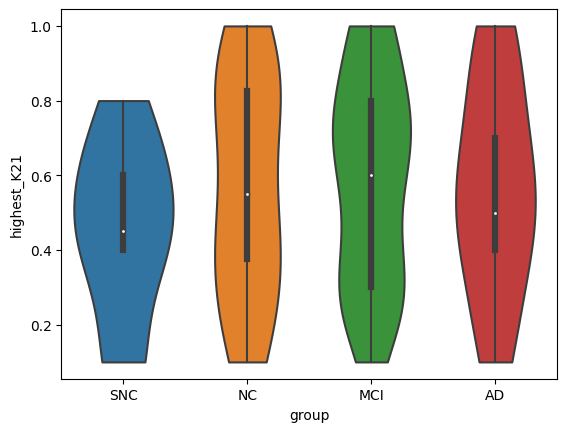

In [8]:
# plot highest_corr based on groups
seaborn.violinplot(x="group", y="highest_K21", data=local_inhibition, cut=0)

<Axes: xlabel='group', ylabel='highest_corr'>

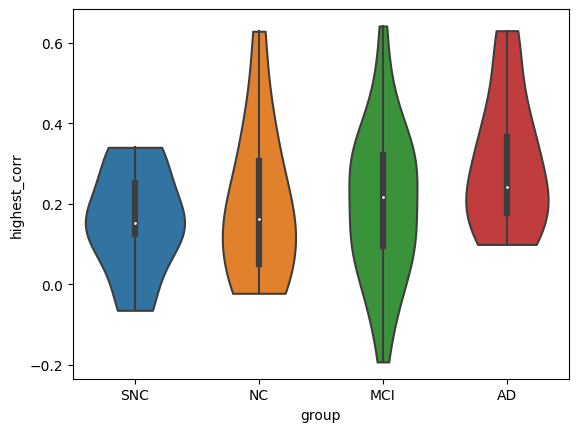

In [7]:
# plot highest_corr based on groups
seaborn.violinplot(x="group", y="highest_corr", data=local_inhibition, cut=0)

In [7]:
long_range = pd.read_csv("/Users/yilewang/Desktop/local_inhibition_long_range.csv")
for case, gr, go, K21 in zip(long_range.caseid, long_range.group, mega_data.Go, long_range.highest_K21):
    # open a txt file
    f = open("K21_fitting", "a")
    if K21 != 1:
        for i in np.arange(K21-0.1, K21+0.1, 0.01):
            i = round(i, 3)
            # generate a string:
            string = f"python K21_fitting.py --Group {gr} --Caseid {case} --Go {go} --K21 {i}"
            # write the string to the file
            f.write(string)
            f.write("\n")
    else:
        pass        
    # close the file
f.close()


In [48]:
# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 'highest_K21', 'highest_corr', "highest_p"])
for gr, case, go in zip(mega_data.group, mega_data.caseid, mega_data.Go):
    # get filenames containing caseid
    filenames = [f for f in os.listdir(pjoin(basedir, gr)) if case in f]
    k_corr = []
    k_21 = []
    p_values = []
    for f in filenames:
        # get K21
        k21 = f.split("_")[1].split(".csv")[0]
        corr,p_value = FC_fitting(gr, case, k21, basedir)
        k_corr.append(corr)
        k_21.append(k21)
        p_values.append(p_value)
    # find the highest correlation coefficient
    if len(k_corr)>0:
        highest_K21 = k_21[np.argmax(k_corr)]
        highest_corr = np.max(k_corr)
        highest_p = p_values[np.argmax(k_corr)]
        local_inhibition.loc[len(local_inhibition)] = [gr, case, highest_K21, highest_corr, highest_p]
    else:
        pass
print(local_inhibition)

   group caseid highest_K21  highest_corr     highest_p
0    SNC  2820A        0.39      0.127492  1.652419e-01
1    SNC  3168A        0.35      0.341340  1.360143e-04
2    SNC  3358A        0.13      0.166309  6.945914e-02
3    SNC  3610A        0.68      0.310028  5.690541e-04
4    SNC  4073A         0.4      0.124517  1.754117e-01
..   ...    ...         ...           ...           ...
69    AD  3255A         0.3      0.192305  3.535882e-02
70    AD  4612A        0.65      0.360600  5.214037e-05
71    AD  5368A        0.83      0.177259  5.276709e-02
72    AD  5571A        0.17      0.366477  3.843246e-05
73    AD  7673A        0.21      0.554203  5.148119e-11

[74 rows x 5 columns]


In [51]:
local_inhibition.to_csv("/Users/yilewang/Desktop/local_inhibition_final.csv", index=False)

Text(0, 0.5, 'Correlation coefficient')

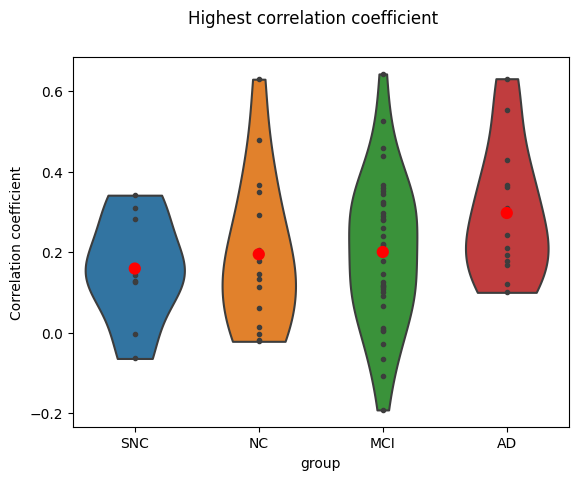

In [52]:
import seaborn as sns
local_inhibition['highest_corr'] = pd.to_numeric(local_inhibition['highest_corr'])
sns.violinplot(x=local_inhibition.group, y=np.array(local_inhibition.highest_corr), cut=0, inner="point")
sns.pointplot(x=local_inhibition.group, y=np.array(local_inhibition.highest_corr), errorbar=None, linestyles="None", capsize=0.2, color="red")
plt.suptitle("Highest correlation coefficient")
plt.ylabel("Correlation coefficient")

Text(0, 0.5, 'K21')

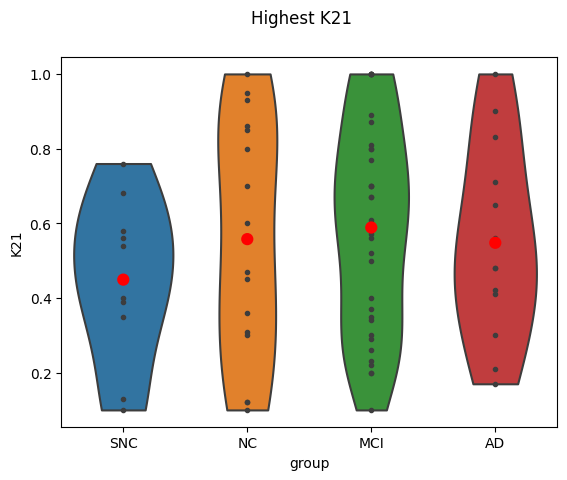

In [53]:
local_inhibition['highest_K21'] = pd.to_numeric(local_inhibition['highest_K21'])
sns.violinplot(x=local_inhibition.group, y=np.array(local_inhibition.highest_K21), cut=0, inner="point")
sns.pointplot(x=local_inhibition.group, y=np.array(local_inhibition.highest_K21), errorbar=None, linestyles="None", capsize=0.2, color="red")
plt.suptitle("Highest K21")
plt.ylabel("K21")

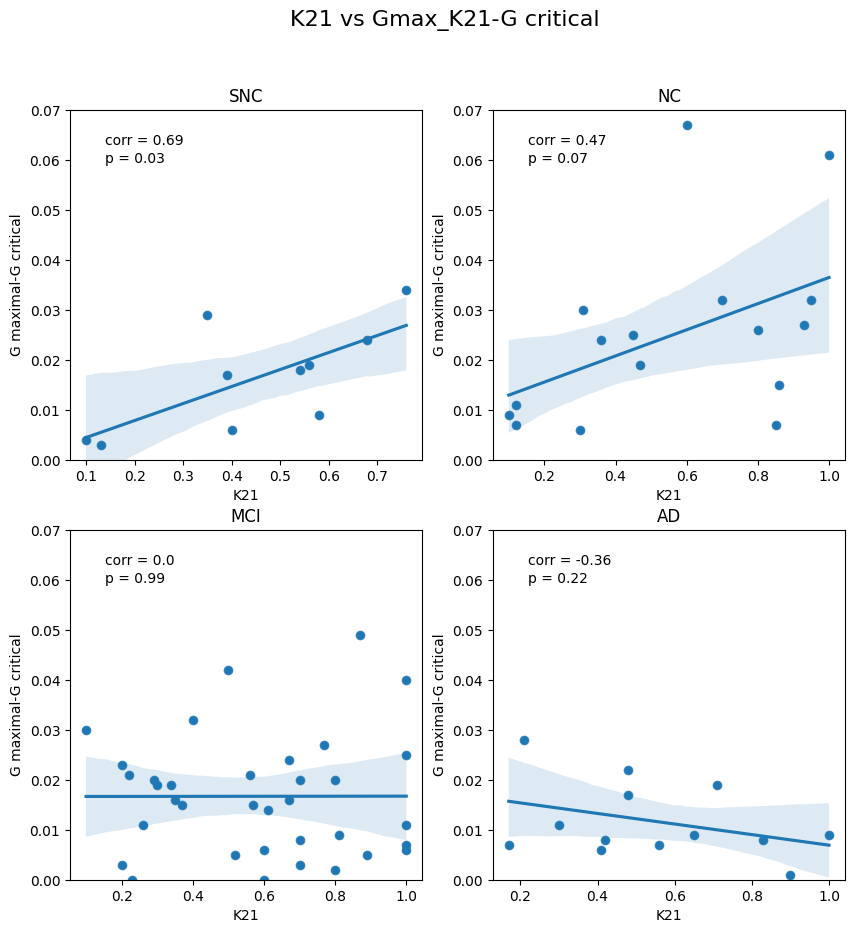

In [19]:
## scatter plot

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy

title = "K21 vs Gmax_K21-G critical"
y_var = "Gmax_K21-Gc"


# read the data
df = pd.read_excel("/Users/yat-lok/workspaces/tvbdemos/clinical_conversion/K21_table.xlsx", sheet_name="gmax")
figure = plt.figure(figsize=(10,10))
figure.suptitle(title, fontsize=16)
for index, grp in enumerate(['SNC','NC','MCI','AD']):
    ax = figure.add_subplot(2,2,index+1)
    # plot the scatterplot, x = K21, y = Gmax_K21 only for SNC
    sns.scatterplot(x="K21", y=y_var, data=df[df.group==grp], ax=ax)
    # plot the regression line
    sns.regplot(x="K21", y=y_var, data=df[df.group==grp], ax=ax)
    # show correlation coefficient, and print p-value
    corr = df[df.group==grp].K21.corr(df[df.group==grp][y_var])
    p_value = scipy.stats.pearsonr(df[df.group==grp].K21, df[df.group==grp][y_var])[1]
    ax.set_ylabel("G maximal-G critical")
    ax.text(0.1, 0.9, "corr = "+str(round(corr, 2)), transform=ax.transAxes)
    ax.text(0.1, 0.85, "p = "+str(round(p_value, 2)), transform=ax.transAxes)
    ax.set_title(grp)
    # make y-axis label from 0.00 to 0.07
    ax.set_ylim([0.00, 0.07])


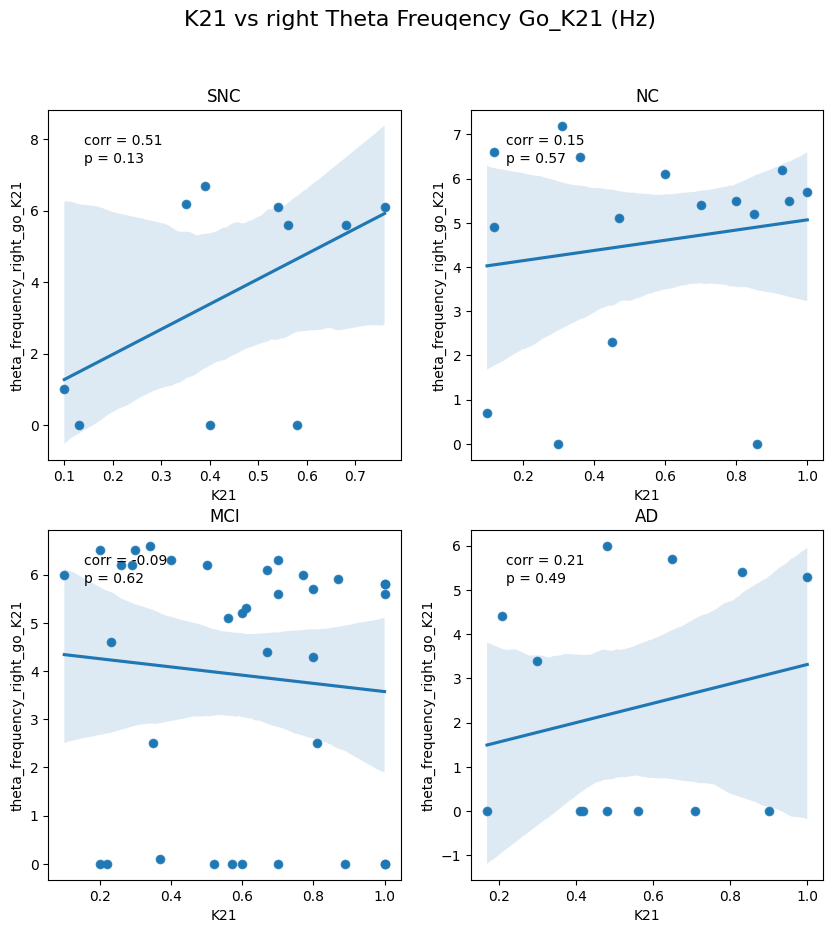

In [9]:
## scatter plot

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy

title = "K21 vs right Theta Freuqency Go_K21 (Hz) "
y_var = "theta_frequency_right_go_K21"

# read the data
df = pd.read_excel("/Users/yat-lok/workspaces/tvbdemos/clinical_conversion/K21_table.xlsx", sheet_name="go")
figure = plt.figure(figsize=(10,10))
figure.suptitle(title, fontsize=16)
for index, grp in enumerate(['SNC','NC','MCI','AD']):
    ax = figure.add_subplot(2,2,index+1)
    # plot the scatterplot, x = K21, y = Gmax_K21 only for SNC
    sns.scatterplot(x="K21", y=y_var, data=df[df.group==grp], ax=ax)
    # plot the regression line
    sns.regplot(x="K21", y=y_var, data=df[df.group==grp], ax=ax)
    # show correlation coefficient, and print p-value
    corr = df[df.group==grp].K21.corr(df[df.group==grp][y_var])
    p_value = scipy.stats.pearsonr(df[df.group==grp].K21, df[df.group==grp][y_var])[1]
    ax.text(0.1, 0.9, "corr = "+str(round(corr, 2)), transform=ax.transAxes)
    ax.text(0.1, 0.85, "p = "+str(round(p_value, 2)), transform=ax.transAxes)
    ax.set_title(grp)